# Configs and Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import (
    VotingClassifier, 
    StackingClassifier, 
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    ExtraTreesClassifier, 
    HistGradientBoostingClassifier
)
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
N_FOLDS = 5
TARGET = 'Target'
SEED = 27

# Loading and Combining the Datasets

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col='id')

train.shape, test.shape

((76518, 37), (51012, 36))

In [4]:
original = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
train = pd.concat([train, original], axis=0, ignore_index=True)

train.shape

(80942, 37)

In [5]:
label_encoder = LabelEncoder()

X = train.drop(TARGET, axis=1)
y = label_encoder.fit_transform(train[TARGET])

# Training

In [6]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')
        
        rskf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)

        accs = []
        aucs = []
        oof_preds = np.zeros((X.shape[0], len(np.unique(y))))
        for fold_idx, (train_idx, val_idx) in enumerate(rskf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            self.model.fit(X_train, y_train)
            
            y_pred_probs = self.model.predict_proba(X_val)
            y_pred = np.argmax(y_pred_probs, axis=1)
            
            oof_preds[val_idx] = y_pred_probs
            
            acc = accuracy_score(y_val, y_pred)
            auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovo')
            accs.append(acc)
            aucs.append(auc)
            
            print(f'--- Fold {fold_idx + 1} - Accuracy: {acc:.6f}, AUC: {auc:.6f}')
            
        print(f'\n--- Accuracy: {np.mean(accs):.6f} +/- {np.std(accs):.6f}')
        print(f'--- AUC: {np.mean(aucs):.6f} +/- {np.std(aucs):.6f}\n\n')
        
        return self.model, oof_preds, accs, aucs

In [7]:
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': SEED,
    'verbose': 0,
    'enable_categorical': True
}

cb_params = {
    'n_estimators': 1200,
    'max_depth': 4,
    'learning_rate': 0.05,
    'random_state': SEED,
    'verbose': 0
}

lgbm_params = {
    'n_estimators': 1200,
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'random_state': SEED,
    'verbose': -1
}

rf_params = {
    'n_estimators': 1200,
    'max_depth': None, 
    'random_state': SEED,
    'verbose': 0
}

gb_params = {
    'n_estimators': 600,
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'random_state': SEED,
    'verbose': 0
}

ab_params = {
    'n_estimators': 1200,
    'learning_rate': 0.05,
    'random_state': SEED
}

et_params = {
    'n_estimators': 1200,
    'max_depth': None,
    'random_state': SEED,
    'verbose': 0
}

hgb_params = {
    'max_iter': 1200,
    'max_depth': 4,
    'random_state': SEED,
    'verbose': 0
}

In [8]:
accuracies = {}
aucs = {}
oof_preds = {}

In [9]:
xgb_model = XGBClassifier(**xgb_params)
xgb_model, xgb_oof_preds, xgb_accs, xgb_aucs = Trainer(xgb_model).fit(X, y)
accuracies['XGB'] = xgb_accs
aucs['XGB'] = xgb_aucs
oof_preds['XGB'] = xgb_oof_preds

cb_model = CatBoostClassifier(**cb_params)
cb_model, cb_oof_preds, cb_accs, cb_aucs = Trainer(cb_model).fit(X, y)
accuracies['CB'] = cb_accs
aucs['CB'] = cb_aucs
oof_preds['CB'] = cb_oof_preds

lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model, lgbm_oof_preds, lgbm_accs, lgbm_aucs = Trainer(lgbm_model).fit(X, y)
accuracies['LGBM'] = lgbm_accs
aucs['LGBM'] = lgbm_aucs
oof_preds['LGBM'] = lgbm_oof_preds

rf_model = RandomForestClassifier(**rf_params)
rf_model, rf_oof_preds, rf_accs, rf_aucs = Trainer(rf_model).fit(X, y)
accuracies['RF'] = rf_accs
aucs['RF'] = rf_aucs
oof_preds['RF'] = rf_oof_preds

gb_model = GradientBoostingClassifier(**gb_params)
gb_model, gb_oof_preds, gb_accs, gb_aucs = Trainer(gb_model).fit(X, y)
accuracies['GB'] = gb_accs
aucs['GB'] = gb_aucs
oof_preds['GB'] = gb_oof_preds

ab_model = AdaBoostClassifier(**ab_params)
ab_model, ab_oof_preds, ab_accs, ab_aucs = Trainer(ab_model).fit(X, y)
accuracies['AB'] = ab_accs
aucs['AB'] = ab_aucs
oof_preds['AB'] = ab_oof_preds

et_model = ExtraTreesClassifier(**et_params)
et_model, et_oof_preds, et_accs, et_aucs = Trainer(et_model).fit(X, y)
accuracies['ET'] = et_accs
aucs['ET'] = et_aucs
oof_preds['ET'] = et_oof_preds

hgb_model = HistGradientBoostingClassifier(**hgb_params)
hgb_model, hgb_oof_preds, hgb_accs, hgb_aucs = Trainer(hgb_model).fit(X, y)
accuracies['HGB'] = hgb_accs
aucs['HGB'] = hgb_aucs
oof_preds['HGB'] = hgb_oof_preds

Training XGBClassifier
--- Fold 1 - Accuracy: 0.831985, AUC: 0.928026
--- Fold 2 - Accuracy: 0.829020, AUC: 0.928659
--- Fold 3 - Accuracy: 0.834075, AUC: 0.931427
--- Fold 4 - Accuracy: 0.834013, AUC: 0.927977
--- Fold 5 - Accuracy: 0.832283, AUC: 0.927580

--- Accuracy: 0.832275 +/- 0.001841
--- AUC: 0.928734 +/- 0.001390


Training CatBoostClassifier
--- Fold 1 - Accuracy: 0.829699, AUC: 0.925552
--- Fold 2 - Accuracy: 0.827043, AUC: 0.925721
--- Fold 3 - Accuracy: 0.830739, AUC: 0.927818
--- Fold 4 - Accuracy: 0.829318, AUC: 0.925925
--- Fold 5 - Accuracy: 0.827959, AUC: 0.924754

--- Accuracy: 0.828952 +/- 0.001305
--- AUC: 0.925954 +/- 0.001013


Training LGBMClassifier
--- Fold 1 - Accuracy: 0.830502, AUC: 0.927543
--- Fold 2 - Accuracy: 0.827290, AUC: 0.927469
--- Fold 3 - Accuracy: 0.833210, AUC: 0.930915
--- Fold 4 - Accuracy: 0.833086, AUC: 0.927117
--- Fold 5 - Accuracy: 0.832530, AUC: 0.927243

--- Accuracy: 0.831324 +/- 0.002239
--- AUC: 0.928057 +/- 0.001437


Training R

In [10]:
estimators = [
    ('XGB', xgb_model),
    ('CB', cb_model),
    ('LGBM', lgbm_model),
    ('RF', rf_model),
    ('GB', gb_model),
    ('AB', ab_model),
    ('ET', et_model),
    ('HGB', hgb_model)
]

voting_model = VotingClassifier(estimators=estimators, voting='soft')
voting_model, voting_oof_preds, voting_accs, voting_aucs = Trainer(voting_model).fit(X, y)
accuracies['Voting'] = voting_accs
aucs['Voting'] = voting_aucs
oof_preds['Voting'] = voting_oof_preds

stacking_model = StackingClassifier(estimators=estimators)
stacking_model, stacking_oof_preds, stacking_accs, stacking_aucs = Trainer(stacking_model).fit(X, y)
accuracies['Stacking'] = stacking_accs
aucs['Stacking'] = stacking_aucs
oof_preds['Stacking'] = stacking_oof_preds

Training VotingClassifier
--- Fold 1 - Accuracy: 0.831429, AUC: 0.927714
--- Fold 2 - Accuracy: 0.829329, AUC: 0.928004
--- Fold 3 - Accuracy: 0.833148, AUC: 0.930287
--- Fold 4 - Accuracy: 0.831480, AUC: 0.927757
--- Fold 5 - Accuracy: 0.831480, AUC: 0.927121

--- Accuracy: 0.831373 +/- 0.001213
--- AUC: 0.928176 +/- 0.001095


Training StackingClassifier
--- Fold 1 - Accuracy: 0.830873, AUC: 0.925755
--- Fold 2 - Accuracy: 0.828402, AUC: 0.926146
--- Fold 3 - Accuracy: 0.832468, AUC: 0.928569
--- Fold 4 - Accuracy: 0.833704, AUC: 0.926721
--- Fold 5 - Accuracy: 0.832468, AUC: 0.925505

--- Accuracy: 0.831583 +/- 0.001827
--- AUC: 0.926539 +/- 0.001095




In [11]:
accuracies = pd.DataFrame(accuracies)
aucs = pd.DataFrame(aucs)

# Results

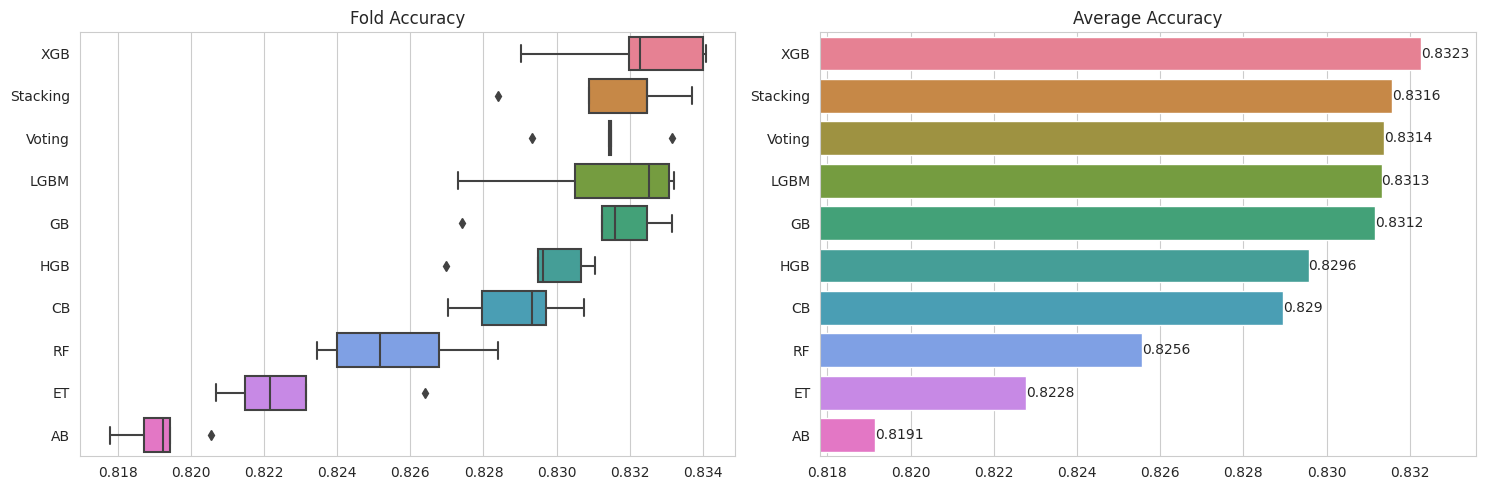

In [12]:
mean_accs = accuracies.mean().sort_values(ascending=False)
order = accuracies.mean().sort_values(ascending=False).index.tolist()

min_acc = mean_accs.min()
max_acc = mean_accs.max()
padding = (max_acc - min_acc) * 0.1
lower_limit = min_acc - padding
upper_limit = max_acc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold Accuracy')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_accs.values, y=mean_accs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average Accuracy')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_accs.values):
    barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

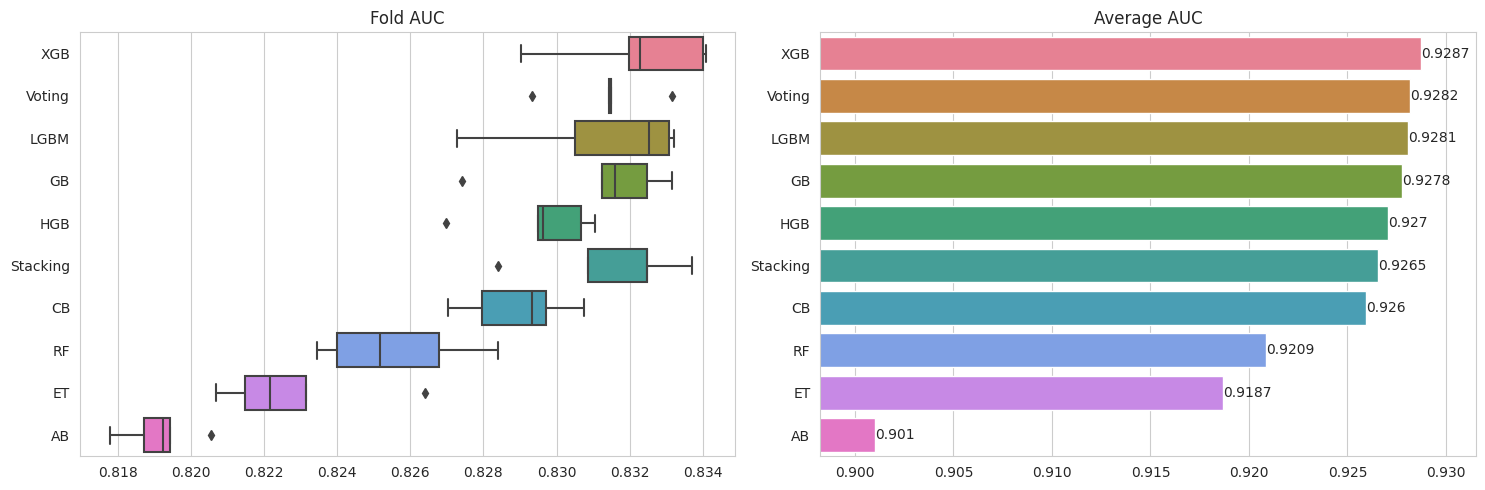

In [13]:
mean_aucs = aucs.mean().sort_values(ascending=False)
order = aucs.mean().sort_values(ascending=False).index.tolist()

min_auc = mean_aucs.min()
max_auc = mean_aucs.max()
padding = (max_auc - min_auc) * 0.1
lower_limit = min_auc - padding
upper_limit = max_auc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=accuracies, order=order, ax=axs[0], palette='husl', orient='h')
axs[0].set_title('Fold AUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_aucs.values, y=mean_aucs.index, ax=axs[1], palette='husl')
axs[1].set_title('Average AUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_aucs.values):
    barplot.text(score, i, round(score, 4), va = 'center')

plt.tight_layout()
plt.show()

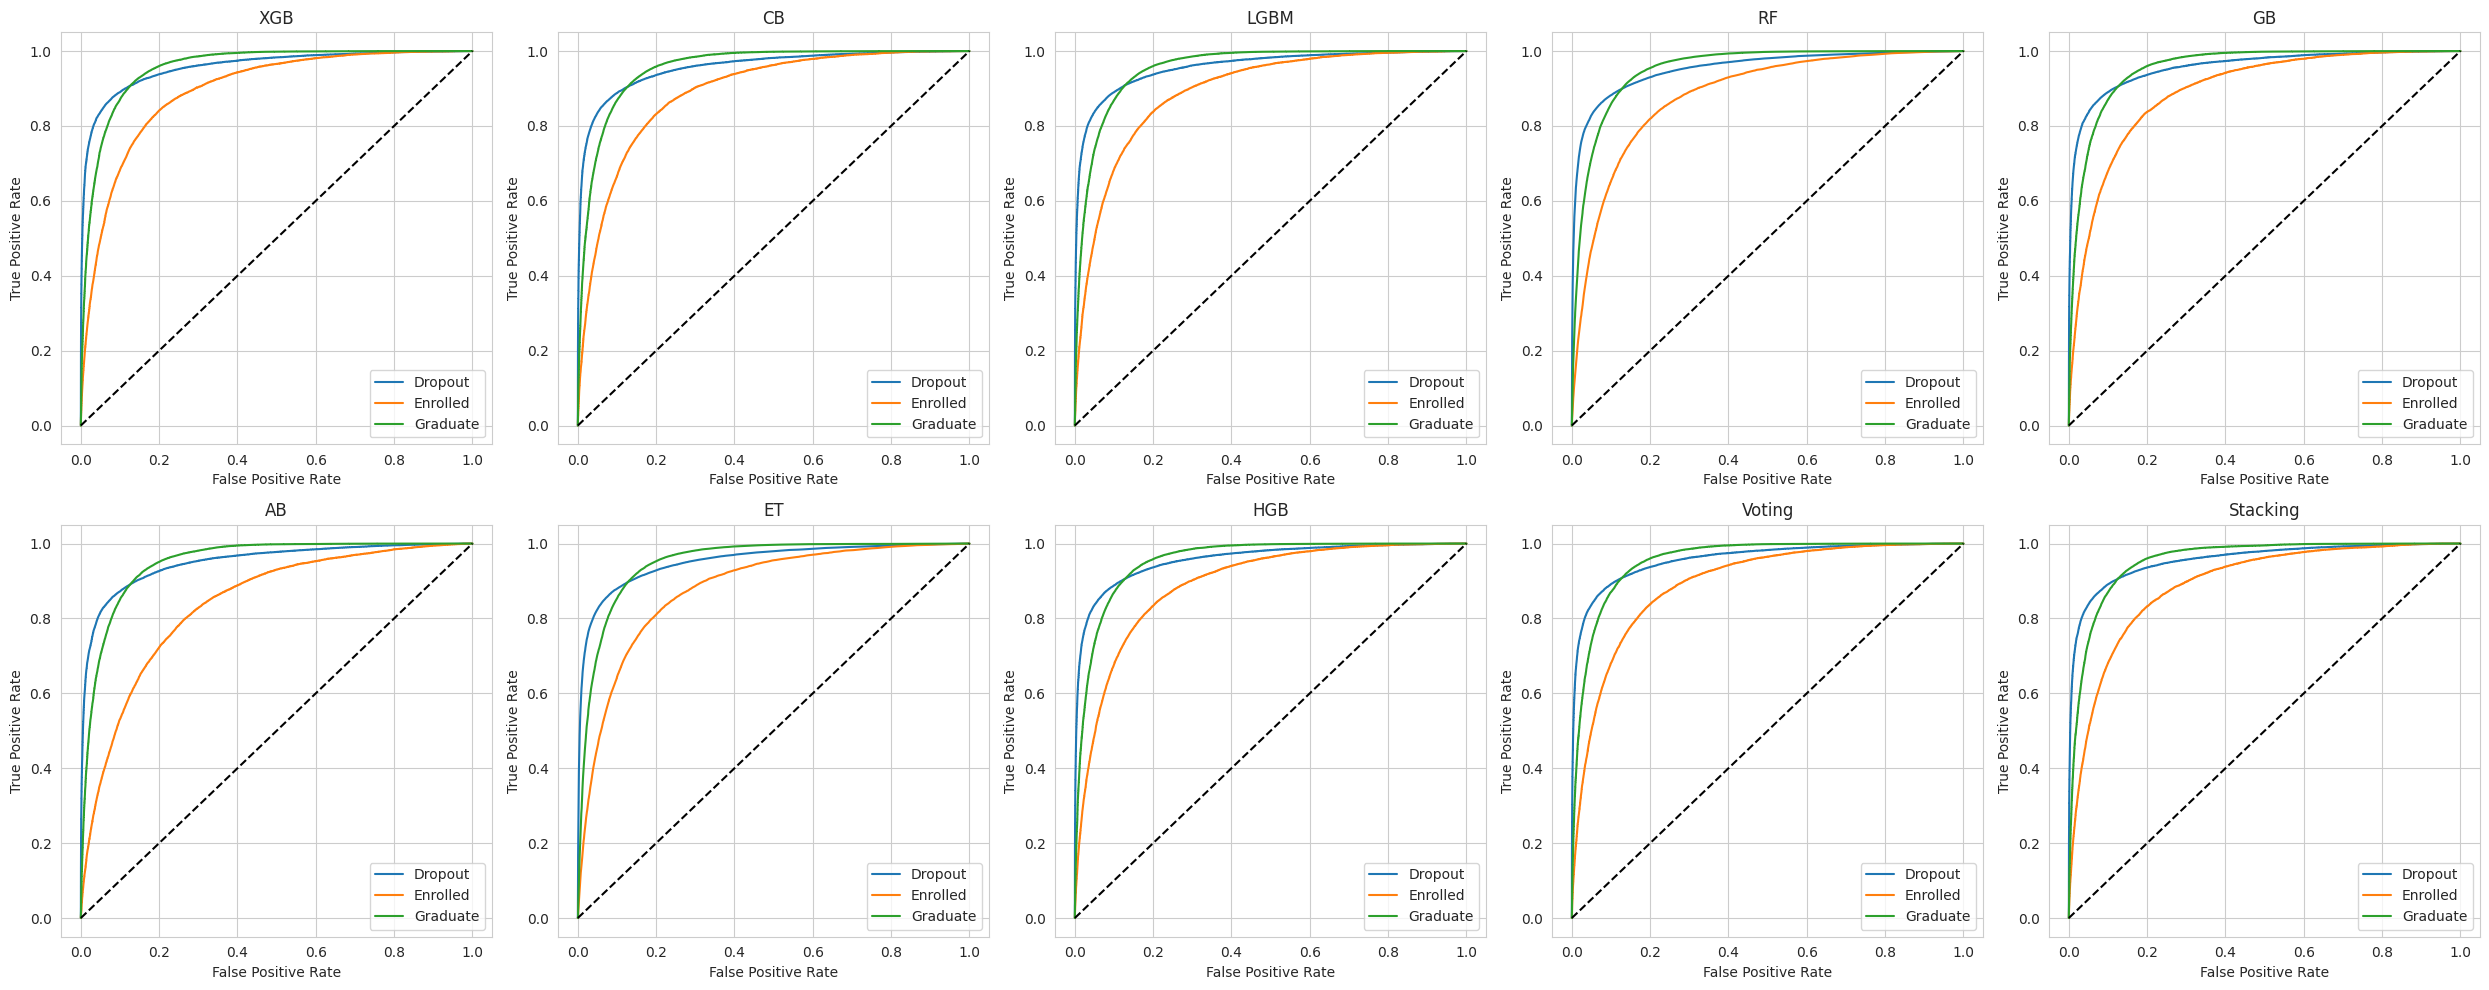

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (model, preds) in zip(axs.flatten(), oof_preds.items()):
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(y, preds[:, i], pos_label=i)
        ax.plot(fpr, tpr, label=f'{label_encoder.inverse_transform([i])[0]}')
        
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax.set_title(model)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

plt.tight_layout()
plt.show()

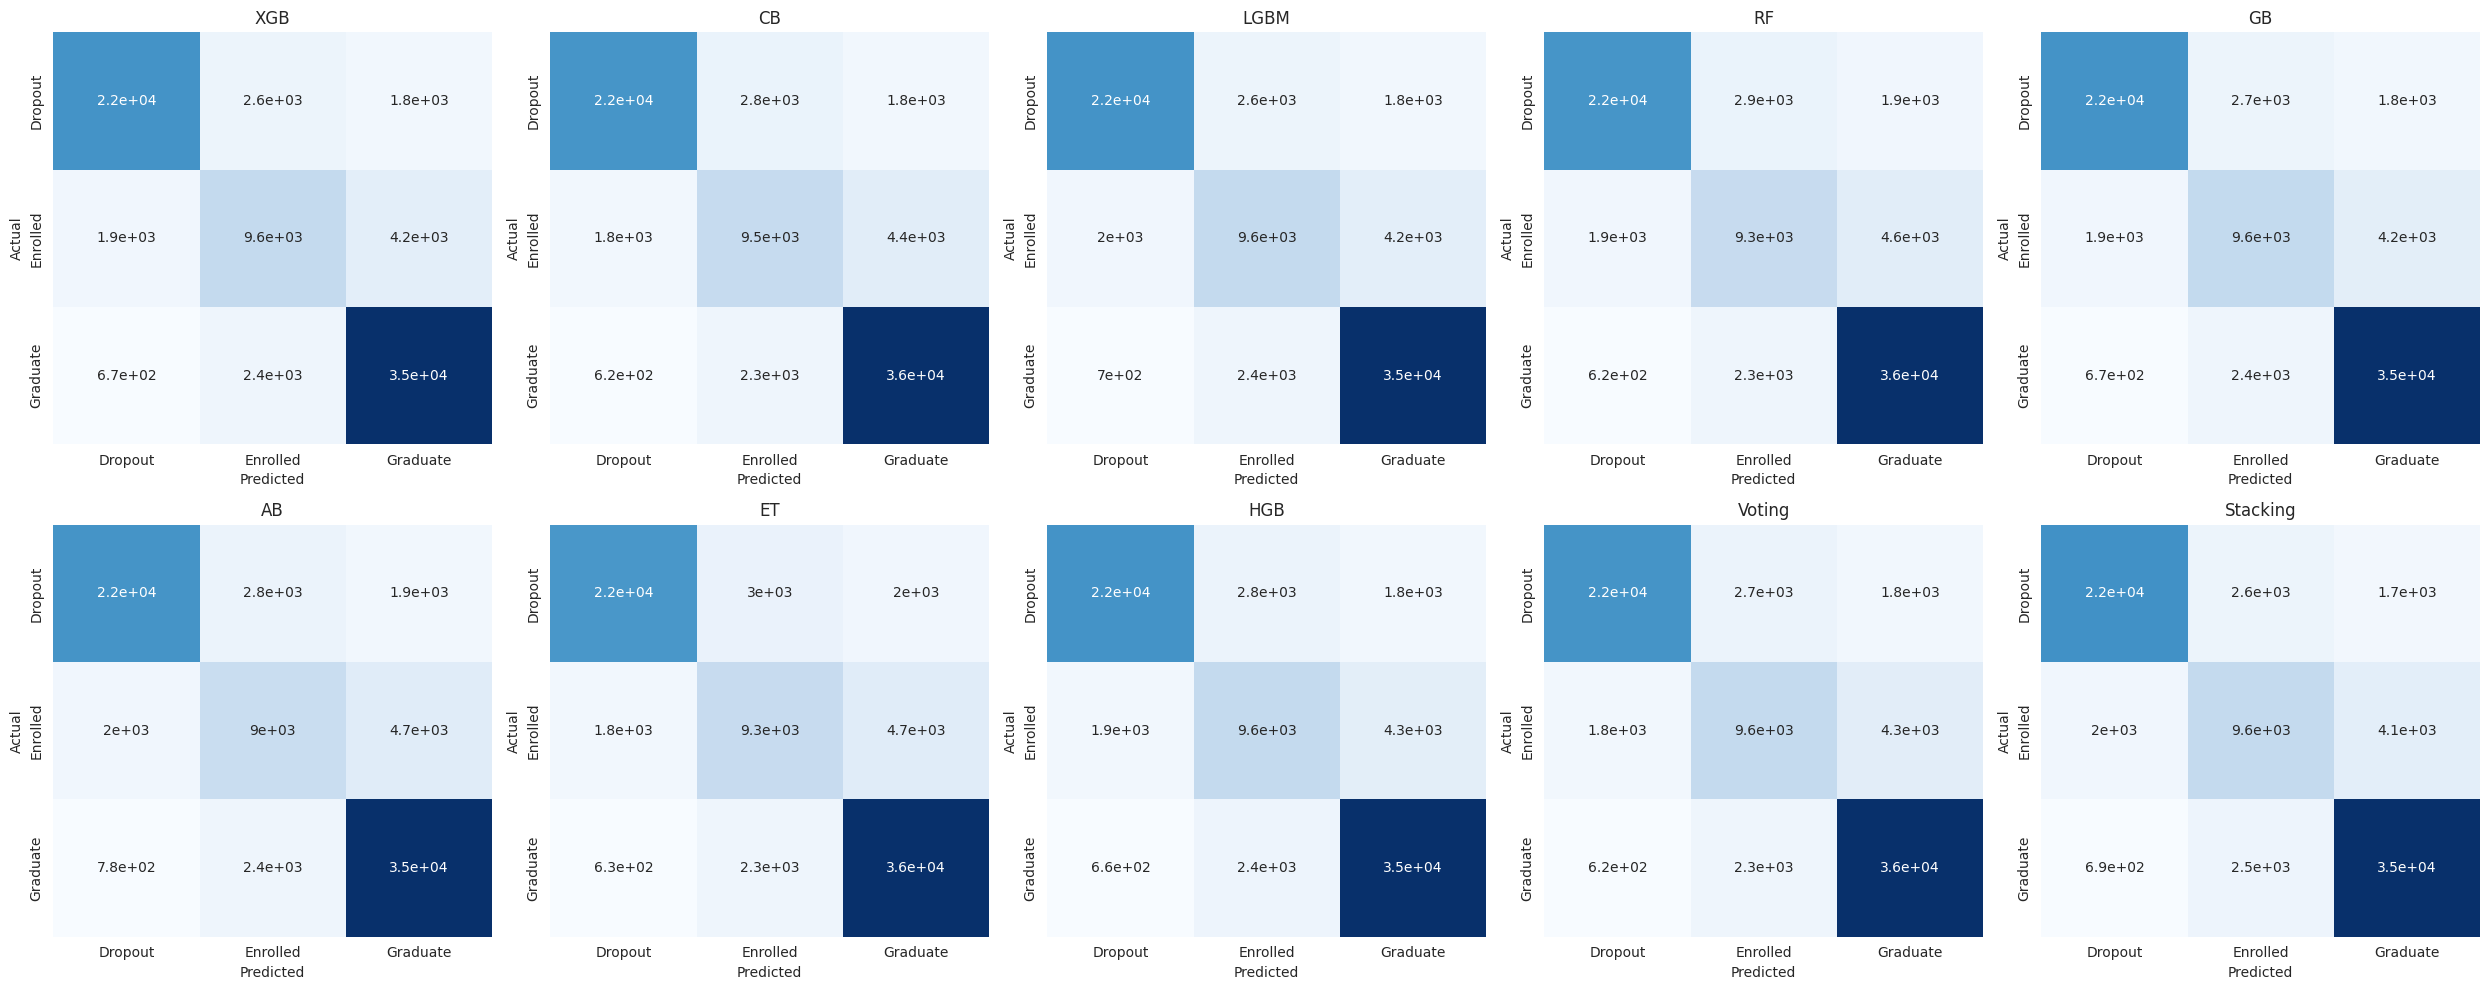

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

for ax, (model, preds) in zip(axs.flatten(), oof_preds.items()):
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
    ax.set_title(model)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
plt.tight_layout()
plt.show()

# Post-Processing and Inference

In [16]:
test_preds = {
    'XGB': xgb_model.predict_proba(test),
    'CB': cb_model.predict_proba(test),
    'LGBM': lgbm_model.predict_proba(test),
    'RF': rf_model.predict_proba(test),
    'GB': gb_model.predict_proba(test),
    'AB': ab_model.predict_proba(test),
    'ET': et_model.predict_proba(test),
    'HGB': hgb_model.predict_proba(test),
    'Voting': voting_model.predict_proba(test),
    'Stacking': stacking_model.predict_proba(test)
}

for model, preds in test_preds.items():
    submission = pd.read_csv('/kaggle/input/playground-series-s4e6/sample_submission.csv')
    submission['Target'] = np.argmax(preds, axis=1)
    submission['Target'] = label_encoder.inverse_transform(submission['Target'])
    submission.to_csv(f'{model}_acc_{mean_accs[model]:.6f}_auc_{mean_aucs[model]:.6f}.csv', index=False)